In [218]:
import re
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [219]:
df = pd.read_csv("GOOGL_day.csv")
df = df.iloc[::-1]
del df['Unnamed: 0']
df

,volume,open,close,high,low,date
1257,1663302.0,930.985,940.810,944.660,929.7900,2017-07-07 04:00:00
1256,1451460.0,941.950,951.000,953.130,941.9500,2017-07-10 04:00:00
1255,1461247.0,950.520,953.530,954.890,945.1200,2017-07-11 04:00:00
1254,1602115.0,960.860,967.660,969.630,957.0400,2017-07-12 04:00:00
1253,1524571.0,970.800,968.850,978.700,964.8000,2017-07-13 04:00:00
...,...,...,...,...,...,...
4,1235841.0,2231.040,2234.030,2263.205,2217.4501,2022-06-29 04:00:00
3,2158453.0,2200.000,2179.260,2217.760,2135.0000,2022-06-30 04:00:00
2,1773783.0,2158.660,2174.750,2185.000,2134.6100,2022-07-01 04:00:00
1,1970154.0,2142.010,2265.260,2267.535,2114.6300,2022-07-05 04:00:00


In [220]:
scaler = MinMaxScaler(feature_range=(0, 1))
y = df['close']
y = y.values.reshape(-1,1)
scaler = scaler.fit(y)
y = scaler.transform(y)

In [221]:
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

def generate_XY():
    """
    This function will generate X,Y as X train and Y train
    Will be modified to be updated regularly
    """
    X = []
    Y = []

    for i in range(n_lookback, (len(y)) - n_forecast + 1):
        X.append(y[i - n_lookback: i])
        Y.append(y[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [222]:

def first_train(X,Y):
    
    model = Sequential()
    model.add(LSTM(units=30,return_sequences=True,input_shape=(n_lookback, 1), activation = 'relu'))
    model.add(LSTM(units=30, return_sequences= True, activation = 'relu'))
    model.add(LSTM(units=30,return_sequences=True, activation = 'relu'))
    model.add(LSTM(units=30, activation = 'relu'))
    model.add(Dense(n_forecast))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X, Y,epochs=5,batch_size=32)
    model.save('future.h5')

def re_train(newX, newY):
    model1 = tf.keras.models.load_model('future.h5')
    model = Sequential([model1])
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(newX, newY, epochs = 5, batch_size=32)

X,Y = generate_XY()
first_train(X,Y)

Epoch 1/5
37/37 [==============================] - 3s 29ms/step - loss: 0.1658
Epoch 2/5
37/37 [==============================] - 1s 30ms/step - loss: 0.0560
Epoch 3/5
37/37 [==============================] - 1s 31ms/step - loss: 0.0117
Epoch 4/5
37/37 [==============================] - 1s 32ms/step - loss: 0.0050
Epoch 5/5
37/37 [==============================] - 1s 32ms/step - loss: 0.0044


In [223]:
# generate the forecasts
model = tf.keras.models.load_model('future.h5')

X_ = y[-n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)


1/1 [==============================] - 0s 228ms/step


In [224]:
df_past = df[['close']]
df_past['date'] = pd.to_datetime(df['date'])
df_past['forecast'] = np.nan
df_past

/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_21599/2978314863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['date'] = pd.to_datetime(df['date'])
/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_21599/2978314863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['forecast'] = np.nan


,close,date,forecast
1257,940.810,2017-07-07 04:00:00,NaN
1256,951.000,2017-07-10 04:00:00,NaN
1255,953.530,2017-07-11 04:00:00,NaN
1254,967.660,2017-07-12 04:00:00,NaN
1253,968.850,2017-07-13 04:00:00,NaN
...,...,...,...
4,2234.030,2022-06-29 04:00:00,NaN
3,2179.260,2022-06-30 04:00:00,NaN
2,2174.750,2022-07-01 04:00:00,NaN
1,2265.260,2022-07-05 04:00:00,NaN


/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_21599/47147154.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('date')


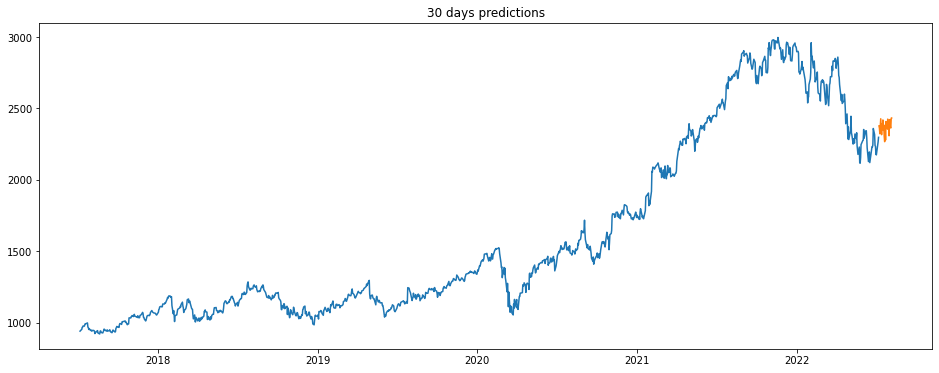

In [225]:
df_future = pd.DataFrame(columns=['close', 'date', 'forecast'])
df_future['date'] = pd.date_range(start=df_past['date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['forecast'] = Y_.flatten()
results = df_past.append(df_future).set_index('date')

plt.figure(figsize=(16,6))
plt.title('30 days predictions')
plt.plot(results)
# plt.savefig('real1.png', dpi = 300, bbox_inches = 'tight')

<AxesSubplot:xlabel='date'>

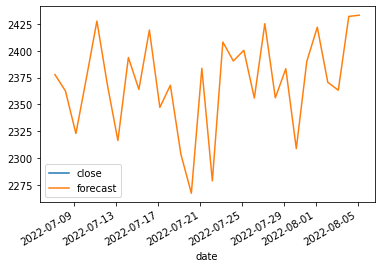

In [228]:
future = df_future.set_index('date')
future.plot()
# plt.savefig('forecast1.png', dpi = 300, bbox_inches = 'tight')